In [1]:
from PIL import Image
from model import AggMInterface
from data import DInterface
import yaml
import warnings
warnings.filterwarnings("ignore")

# 指定模型的超参数配置文件路径和checkpoint文件路径
config_path = "/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/logs/dinov2_backbone_dinov2_large/lightning_logs/version_1/hparams.yaml"
checkpoint_path = "/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/logs/dinov2_backbone_dinov2_large/lightning_logs/version_1/checkpoints/dinov2_backbone_epoch(15)_step(15632)_R1[0.8946]_R5[0.9554]_R10[0.9608].ckpt"

# 加载yaml文件，获取模型超参数配置
with open(config_path) as f:
    config = yaml.safe_load(f)

# 根据配置初始化数据模块
data_module = DInterface(**config)  # 数据模块初始化，传入配置参数
transform = data_module.valid_transform  # 获取验证集的数据变换方法

# 根据checkpoint文件路径加载模型，并设置为评估模式
model = AggMInterface.load_from_checkpoint(checkpoint_path)
model.eval()
model = model.model.model

/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/utils/hook_func.py:19: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


正在尝试从以下路径导入模块: .dinov2_backbone
正在查找类: Dinov2Backbone


In [2]:
from einops import rearrange
from utils.hook_func import extract_features
from visualization import get_pca_map
import numpy as np
import os
import matplotlib.pyplot as plt

def visualize_dinov2_pca(model, input_image_path, facet_layer_and_facet={23: 'token'},save_path=None):
    # 定义加载图像并resize，输出tensor的transform
    ori_image = Image.open(input_image_path).convert("RGB")
    
    # 获取transform后的图像
    image = transform(ori_image).unsqueeze(0).cuda()
    image_size = (image.shape[2], image.shape[3])  # 获取transform后的图像尺寸
    print(f"Transformed image shape: {image.shape}")

    # 为模型注册hook以提取特征
    feats = extract_features(model, image, facet_layer_and_facet)
    print(f"Features shape: {feats[0].shape}")
    patch_tokens = feats[0][:,1:,:]
    print(f"Patch tokens shape: {patch_tokens.shape}")

    # 获取特征图
    features = patch_tokens.detach().cpu()
    features = rearrange(features, 'b (h w) c -> b h w c', 
                        h=int(image_size[0]/14), w=int(image_size[1]/14))
    features = features[0].float()

    # 生成PCA可视化图
    color = get_pca_map(features, image_size, interpolation='bilinear')
    color = (color*255).astype(np.uint8)
    print(f"PCA map shape: {color.shape}")

    # 拼接原始图像和PCA图
    image = np.hstack((ori_image.resize(image_size), color))
    print(f"Final image shape: {image.shape}")

    if save_path is not None:
        # 使用指定的保存路径
        rgb_image = Image.fromarray(image)
        rgb_image.save(save_path)
    else:
        # 使用 matplotlib 显示图像
        plt.figure(figsize=(8, 3))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

Transformed image shape: torch.Size([1, 3, 560, 560])
Features shape: torch.Size([1, 1601, 1024])
Patch tokens shape: torch.Size([1, 1600, 1024])
PCA map shape: (560, 560, 3)
Final image shape: (560, 1120, 3)


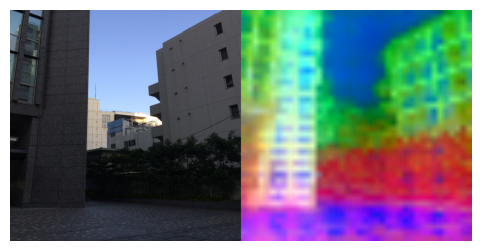

In [12]:
# 可视化单张图像
input_image_path = r"/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/tmp_imgs/00266.jpg"
facet_layer_and_facet = {15: 'token'}
save_path=None  
visualize_dinov2_pca(model, input_image_path, facet_layer_and_facet,save_path)

找到 5 张图片
Transformed image shape: torch.Size([1, 3, 560, 560])
Features shape: torch.Size([1, 1601, 1024])
Patch tokens shape: torch.Size([1, 1600, 1024])
PCA map shape: (560, 560, 3)
Final image shape: (560, 1120, 3)


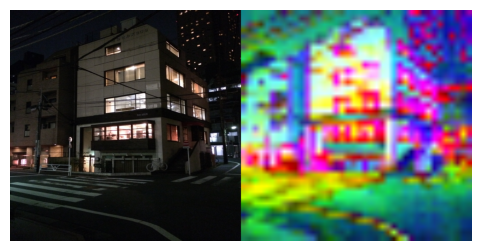

Transformed image shape: torch.Size([1, 3, 560, 560])
Features shape: torch.Size([1, 1601, 1024])
Patch tokens shape: torch.Size([1, 1600, 1024])
PCA map shape: (560, 560, 3)
Final image shape: (560, 1120, 3)


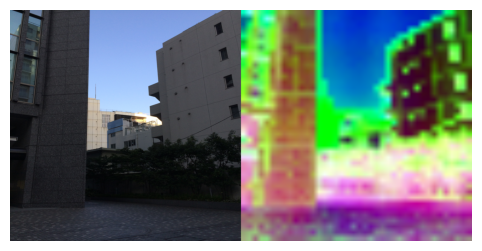

Transformed image shape: torch.Size([1, 3, 560, 560])
Features shape: torch.Size([1, 1601, 1024])
Patch tokens shape: torch.Size([1, 1600, 1024])
PCA map shape: (560, 560, 3)
Final image shape: (560, 1120, 3)


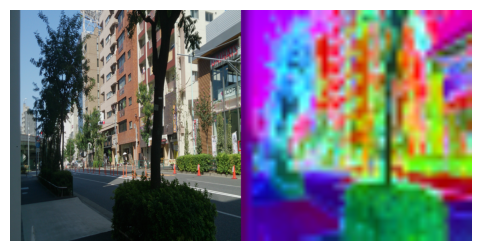

Transformed image shape: torch.Size([1, 3, 560, 560])
Features shape: torch.Size([1, 1601, 1024])
Patch tokens shape: torch.Size([1, 1600, 1024])
PCA map shape: (560, 560, 3)
Final image shape: (560, 1120, 3)


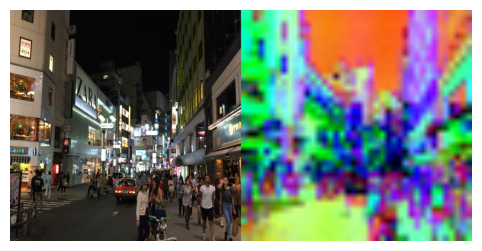

Transformed image shape: torch.Size([1, 3, 560, 560])
Features shape: torch.Size([1, 1601, 1024])
Patch tokens shape: torch.Size([1, 1600, 1024])
PCA map shape: (560, 560, 3)
Final image shape: (560, 1120, 3)


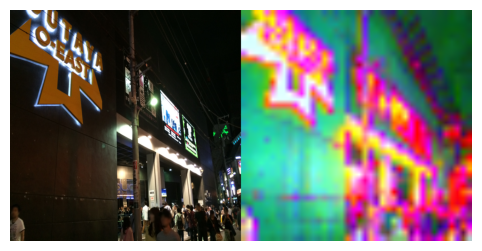

In [37]:
import glob

# 可视化多张图像
img_path = "/media/cartolab3/DataDisk/wuqilong_file/Projects/RerenkVPR/tmp_imgs"
image_list = glob.glob(os.path.join(img_path, "*.jpg"))
print(f"找到 {len(image_list)} 张图片")

for image_path in image_list:
    # 为每张图片生成对应的保存路径
    save_name = os.path.basename(image_path)
    save_name = f"dinov2_{save_name}"
    save_path = os.path.join(img_path, save_name)
    
    # 调用可视化函数，注意传入所有必要参数
    visualize_dinov2_pca(
        model=model,
        input_image_path=image_path,
        facet_layer_and_facet=facet_layer_and_facet,
        save_path=None
    )